# Simple Recurrent Network - Many-to-Many Sequence Learning

Here we will develop a simple recurrent network to solve a relatively simple, but non-trivial sequence learning task. The goal is to use a simple recurrent neural network (RNN) architecture to solve the problem while investigating the basic decisions needed to prepare the input/target data patterns and train such an architecture. You should already become familiar with feed-forward single- and multi-layer networks before attempting this tutorial, as we will be using many of the same tools to investigate the RNN and will assume familiarity on your part with those tools.

Let's load some of the tools we will be using. Keras for network building/training, numpy for everything, matplotlib for plots, keras_tdqm for graphical updating of the learning process (will not render without jupyter widgets), and vis_utils for simple visualization of the network structure (which could be better: we should make some pull-requests!)

In [1]:
import keras

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from keras_tqdm import TQDMNotebookCallback

# Visualization
from IPython.display import SVG, HTML
from IPython.display import display
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
# Hack to fix TQDM extra lines issue...
# Reference: https://github.com/bstriner/keras-tqdm/issues/21
from keras_tqdm import TQDMNotebookCallback
display(HTML("""
    <style>
        .p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
              padding: 0;
              border: 0;
        }
    </style>
"""))

Our problem will consist of the solution to the even/odd parity determination for a binary sequence. The problem is very easy to solve using a feed-forward neural network when providing an entire sequence of binary digits as input, but we would like to cast the problem into one amenable for sequence learning. Therefore, we will utilize an *iterative* approach to parity determination which starts at the most significant (left) side of a sequence of digits and proceeds to the least significant (right) side while keeping track of whether an odd or even number of 1s have been observed so far. The empty sequence is assumed even, and the inherent non-linearity of the parity determination problem can be observed for the case of 2-digit binary inputs which degenerates into a logical XOR. The iterative parity problem is therefore a natural sequential extension to the standard XOR problem.

For example, if we have the binary sequence 1010111001, then we have an even number of ones and the sequence has even parity. For the sequence 1011111001, we have an odd number of ones and the sequence has odd parity. However, turning this into an iterative problem means we move from the left to the right and decide to map each digit to even (0) or odd (1), based on whether we have encountered an even or odd number of ones so far in the sequence:

| Input: | 1 | 0 | 1 | 0 | 1 | 1 | 1 | 0 | 0 | 1 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Output: | 1 | 1 | 0 | 0 | 1 | 0 | 1 | 1 | 1 | 0 |

or for the second sequence:

| Input: | 1 | 0 | 1 | 1 | 1 | 1 | 1 | 0 | 0 | 1 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Output:| 1 | 1 | 0 | 1 | 0 | 1 | 0 | 0 | 0 | 1 |

Therefore, the neural network will be presented with each input (one bit at a time) which by themselves are not enough to make a determination of parity. Instead, it must learn to maintain some internal representation (internal state) of whether it has seen an even or odd number of ones so far. Then, using this internal representation *and* the current input, it can decide how to decode the current input and also how to update the internal representation for the next digit in the sequence.

In [3]:
# Length of sequences to model
length = 10

We can adjust `length` above to change the length of the binary sequences which are presented to the network.

For now, we will craft just a single example for learning. It's always good to start with just a single sequence to test your network before moving on to use more (or more complex) data.

For RNNs, the keras tools will expect inputs to be delivered as a 3D tensor N x M x S where N is the number of training sequences, M is the number of timesteps (sequence length), and S is the length of the input vectors delivered to the network (actual input layer size). N=1 since we have only one pattern (for now), and M=`length` since we are presenting one digit on each time step, and S=1 since each input vector is just a single binary digit.

Numpy is used to generate some random numbers between 0 and 1, which are then rounded (either 0 or 1). After that, we just reshape the vector into a tensor (multidimensional array) of the appropriate size.

In [4]:
# General random vector of binary values - just reshape below
np.round(np.random.uniform(0,1,[length])).reshape([1,length])

array([[1., 1., 1., 0., 1., 0., 0., 0., 1., 0.]])

In [5]:
# Generate a random string of 0s and 1s
x_train = np.round(np.random.uniform(0,1,[length])).reshape([1,length,1])
x_train

array([[[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]]])

In [6]:
# Calculate parity (note this is the same algorithmic approach
# that we are trying to encourage our net to learn!)
def parity(x):
    temp = np.zeros(x.shape)
    mem = False
    # Iterate over the sequence
    for i in range(x.shape[0]):
        if x[i,0] > 0.5:
            current = True
        else:
            current= False
        mem = np.logical_xor(mem,current)
        if mem:
            temp[i,0] = 1.0
        else:
            temp[i,0] = 0.0
    return (temp.reshape(1,temp.shape[0],temp.shape[1])) # Tensor!

In [7]:
y_train = parity(x_train[0,:,:])
y_train

array([[[1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.]]])

Now that we have a many-to-many (many inputs to many targets) sequence set (with just one sequence) in the `x_train` and `y_train` tensors, we are ready to set up our simple RNN to train on this sequence...

We just need to utilize the `SimpleRNN` layer to create a hidden layer with a set of recurrent connection weights back to itself. Also, the `Dense` layer which follows is applied to each of the outputs from the hidden layer on *each timestep*. This has implications for deeper networks if we decided to add some layers after (or before) the `Dense`. Nevertheless, it's the intention of the output layer to consider each timestep in this way. If we only wanted to know the final output (many-to-one) we would indicate this to the `SimpleRNN` layer by telling it not to `return_sequences` (see below). Otherwise, we use a reasonable number of units on the `SimpleRNN` layer to ensure that we have plenty of room to store a complicated internal representation of the current state of the sequence when needed (you might try reducing this value some and see what kinds of things happen). Also, the `return_sequences` option is set to `True` for the many-to-many net, which ensures that each of the timesteps are provided to layers downstream. This is needed if you were interested in stacking `SimpleRNN` layers for instance to create a *deep recurrent network*. Finally, the `input_shape` is set to the M x S parameters from our data tensors, where N is assumed to vary based on how many training sequences we decide use during the `fit()` (training) phase.

In [8]:
# Network creation - Many-to-Many
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(20,activation='relu',return_sequences=True,input_shape=(None,1)))
model.add(keras.layers.Dense(1,activation='sigmoid'))
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Nadam(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           21        
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


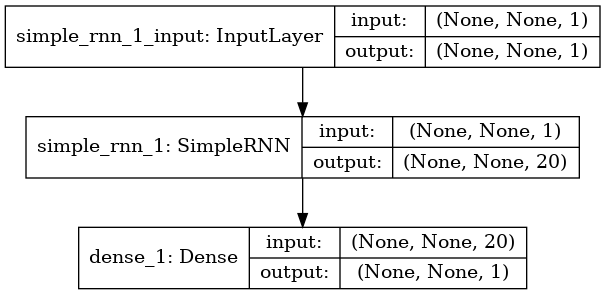

In [9]:
# Visualization - wish we could see the recurrent weights!
plot_model(model,to_file='srnn.png',show_shapes=True,expand_nested=True)

In [10]:
# Network creation - Many-to-One
model2 = keras.Sequential()
model2.add(keras.layers.SimpleRNN(int(length*2),activation='relu',return_sequences=False,input_shape=(None,1)))
model2.add(keras.layers.Dense(1,activation='sigmoid'))
model2.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Nadam(),
              metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 20)                440       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


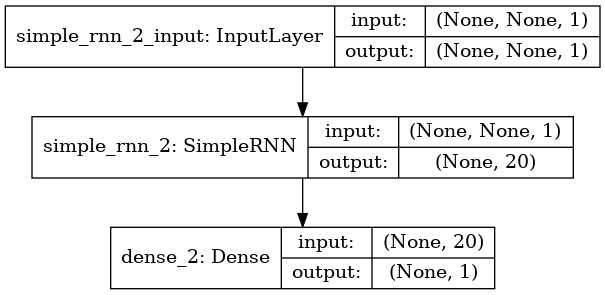

In [11]:
# Visualization - wish we could see the recurrent weights!
plot_model(model2,to_file='srnn2.png',show_shapes=True,expand_nested=True)

In [12]:
# Many-to-Many Training
batch_size = 1   # only one pattern...
epochs = 200
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          callbacks=[TQDMNotebookCallback()])
print('Accuracy:',model.evaluate(x_train,y_train)[1]*100.0,'%')


1/1 [==============================] - 0s 107ms/step
Accuracy: 100.0 %


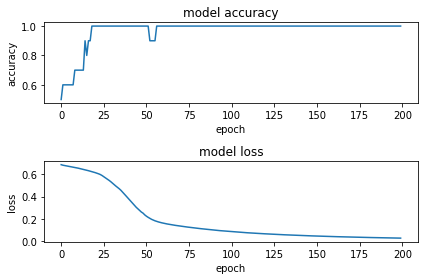

In [13]:
plt.figure(1)  
   
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
   
# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  

plt.tight_layout()
plt.show()  

In [14]:
# Many-to-One Training
batch_size = 1   # only one pattern...
epochs = 200
history2 = model2.fit(x_train, y_train[:,length-1,:],
           batch_size=batch_size,
           epochs=epochs,
           verbose=0,
           callbacks=[TQDMNotebookCallback()])
print('Accuracy:',model2.evaluate(x_train,y_train[:,length-1,:])[1]*100.0,'%')


1/1 [==============================] - 0s 100ms/step
Accuracy: 100.0 %


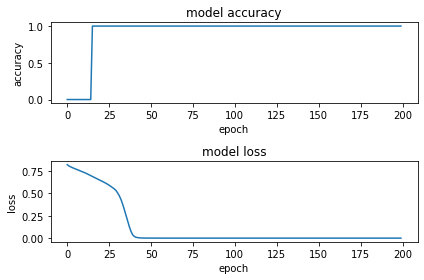

In [15]:
plt.figure(1)  
   
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history2.history['accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
   
# summarize history for loss  

plt.subplot(212)  
plt.plot(history2.history['loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  

plt.tight_layout()
plt.show()  

100% accuracy on a single sequence is the first step in training many-to-many networks...

Now, let's see that output first-hand by using the `predict()` function.

In [16]:
# Approximate result
model.predict(x_train)

array([[[8.1334406e-01],
        [5.6775775e-02],
        [9.9567646e-01],
        [2.4925984e-04],
        [7.0825254e-04],
        [1.3202246e-06],
        [9.9996209e-01],
        [9.9985385e-01],
        [1.0000000e+00],
        [1.4030586e-28]]], dtype=float32)

In [17]:
# Rounded to closest binary value (counted as correct)
np.round(model.predict(x_train))

array([[[1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.]]], dtype=float32)

In [18]:
# Check against the y_train vector
y_train

array([[[1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.]]])

Now that we can train a network to learn a single sequence, let's increase the amount of training data and get the network to learn the parity function completely. We will use 100 sequences for training (X,Y), and also generate 100 for testing (X_test,Y_test). We use the same functions as before, but will use a list-comprehension to perform the input-output generation steps `n_seq`=100 times, and the `concatenate()` method for combining those along the first dimension (by default, which is convenient for this example, but can also be changed if needed).

In [19]:
# Generate a concatenation of sequences
n_seq = 100
X = np.concatenate([np.round(np.random.uniform(0,1,[length])).reshape([1,length,1]) for i in range(n_seq)])
X_test = np.concatenate([np.round(np.random.uniform(0,1,[length])).reshape([1,length,1]) for i in range(n_seq)])
X.shape

(100, 10, 1)

In [20]:
Y = np.concatenate([parity(X[i,:,:]) for i in range(n_seq)])
Y_test = np.concatenate([parity(X_test[i,:,:]) for i in range(n_seq)])
Y.shape

(100, 10, 1)

In [21]:
# Look at the first set for confirmation
X[0,:,:]

array([[0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [22]:
Y[0,:,:]

array([[0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.]])

Recreate the model for training, same as above really...

In [23]:
# Network creation - Many-to-Many
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(20,activation='relu',return_sequences=True,input_shape=(None,1)))
model.add(keras.layers.Dense(1,activation='sigmoid'))
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Nadam(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)           21        
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Network creation - Many-to-One
model2 = keras.Sequential()
model2.add(keras.layers.SimpleRNN(20,activation='relu',return_sequences=False,input_shape=(None,1)))
model2.add(keras.layers.Dense(1,activation='sigmoid'))
model2.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Nadam(),
              metrics=['accuracy'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 20)                440       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


This time we will use some validation data to help follow the generalization properties of the network while training, just 20% of the available sequences (be careful not to use too small of a data set with this cell!)

In [25]:
# Many-to-Many Training
batch_size = min(20,X.shape[0]) # Either 20 or the number of patterns if fewer than 20...
epochs = 300
history = model.fit(X, Y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_split=0.2, 
          callbacks=[TQDMNotebookCallback()])
print('Training Accuracy:',model.evaluate(X,Y)[1]*100.0,'%')
print('Testing Accuracy:',model.evaluate(X_test, Y_test)[1]*100.0,'%')


100/100 [==============================] - 0s 92us/step
Training Accuracy: 100.0 %
100/100 [==============================] - 0s 79us/step
Testing Accuracy: 100.0 %


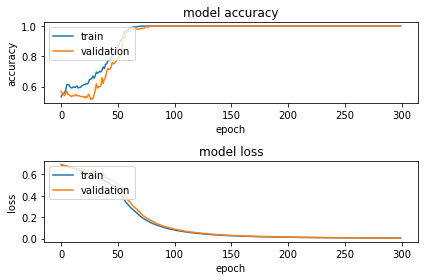

In [26]:
plt.figure(1)  
   
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
   
# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')

plt.tight_layout()
plt.show()  

In [27]:
# Many-to-One Training
batch_size = min(20,X.shape[0]) # Either 20 or the number of patterns if fewer than 20...
epochs = 300
history2 = model2.fit(X, Y[:,length-1,:],
           batch_size=batch_size,
           epochs=epochs,
           verbose=0,
           validation_split=0.2, 
           callbacks=[TQDMNotebookCallback()])
print('Training Accuracy:',model2.evaluate(X,Y[:,length-1,:])[1]*100.0,'%')
print('Testing Accuracy:',model2.evaluate(X_test, Y_test[:,length-1,:])[1]*100.0,'%')


100/100 [==============================] - 0s 82us/step
Training Accuracy: 91.00000262260437 %
100/100 [==============================] - 0s 88us/step
Testing Accuracy: 50.0 %


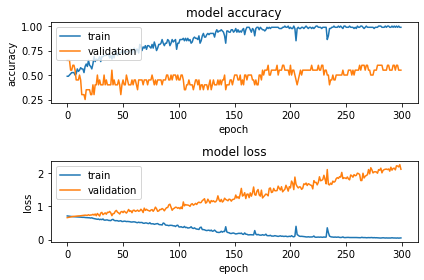

In [28]:
plt.figure(1)  
   
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history2.history['accuracy'])  
plt.plot(history2.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
   
# summarize history for loss  

plt.subplot(212)  
plt.plot(history2.history['loss'])  
plt.plot(history2.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')

plt.tight_layout()
plt.show()  

In [29]:
# Pick a pattern, any pattern...
p = 0
X_test[p:p+1,:,:]

array([[[0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.]]])

In [30]:
# Easier to see when rounded... (Should match -all- tokens below)
np.round(model.predict(X_test[p:p+1,:,:]))

array([[[0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.]]], dtype=float32)

In [31]:
# Easier to see when rounded... (Should just match last token below)
np.round(model2.predict(X_test[p:p+1,:,:]))

array([[0.]], dtype=float32)

In [32]:
# Compare with corresponding result!
Y_test[p:p+1,:,:]

array([[[0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.]]])

Now you've trained a simple RNN to solve the parity problem! However, these networks are still a little limited in efficacy since we have chosen a fixed input size (M). You could choose to set M to the largest sequence you expect to ever encounter and then just pad any shorter sequences with extra zeros or use a `Masking()` layer just prior to your `SimpleRNN` layer which will turn off the input when it is a certain value (could use something like 0.5 for this example).

Also, you can see that the many-to-one mapping which just tried to learn the final parity assignment from the sequence was not nearly as successful at learning the task as the many-to-many mapping. Those additional feedback/targets provided on each step really make a critical difference. However, one might start by training very short sequences, and then slowly grow the size of the sequences to try to shape the training of this network. Shaping these nets by varying the training regime can make a very big improvement in the end.

More importantly, if you were feeding in words a character at a time in all lower-case, then you might set S=27 and let each input pattern be a one-hot encoding for a particular letter (the 27th element would be for "whitespace" or "terminator" character). If you are encoding documents at the word-level (instead of the character-level) you might determine the number of unique words are in your text corpus after stemming, etc. and let S be that number instead (now, one-hot encoding each input based on a word). We will explore these kinds of encodings more with more powerful RNN architectures soon.